1. Configuración de la sesión Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Crear sesión de Spark con configuración para MinIO
spark = SparkSession.builder \
    .appName("OrderLinesBatchProcessing") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .getOrCreate()


print("✅ Spark Session creada")
print(f"Versión de Spark: {spark.version}")

✅ Spark Session creada
Versión de Spark: 3.5.0


2. Lectura de Datos (Filtro por Partición)

In [2]:
# Leemos el bucket de humedad
df_hum = spark.read.json("s3a://humidity-sensors/")

# Verificamos los datos cargados
df_hum.show(5)

+--------+-----------+---------+--------------------+---------+
|humidity|   location|sensor_id|           timestamp|partition|
+--------+-----------+---------+--------------------+---------+
|   35.12|Warehouse_A|   HUM_01|2026-02-18T16:36:...|        0|
|   38.89|Warehouse_A|   HUM_01|2026-02-18T16:36:...|        0|
|   40.79|Warehouse_A|   HUM_01|2026-02-18T16:37:...|        0|
|   43.79|Warehouse_A|   HUM_01|2026-02-18T16:37:...|        0|
|   44.38|Warehouse_A|   HUM_01|2026-02-18T16:37:...|        0|
+--------+-----------+---------+--------------------+---------+
only showing top 5 rows



3. Cálculo de Métricas por Sensor

In [3]:
# Extraemos la hora y calculamos el promedio
# Asumiendo que 'timestamp' está en formato ISO o casted a Timestamp
df_hourly_hum = df_hum.withColumn("hora_dia", hour(col("timestamp"))) \
    .groupBy("hora_dia") \
    .agg(round(avg("humidity"), 2).alias("humedad_media")) \
    .orderBy("hora_dia")

df_hourly_hum.show(24)

+--------+-------------+
|hora_dia|humedad_media|
+--------+-------------+
|      16|        39.96|
|      17|        40.08|
+--------+-------------+



4. Visualización de la Tendencia

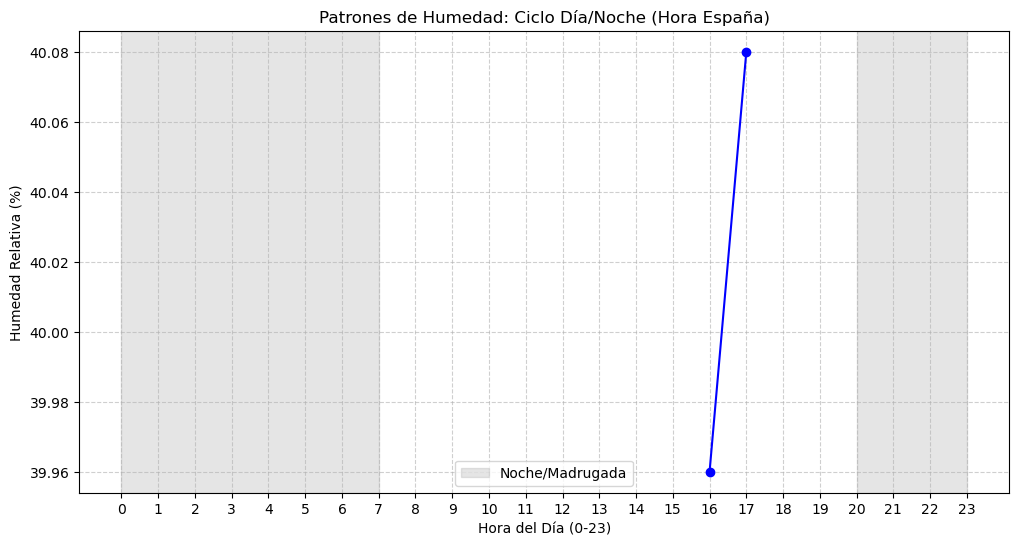

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir a Pandas para graficar
pdf_hum = df_hourly_hum.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pdf_hum['hora_dia'], pdf_hum['humedad_media'], color='blue', marker='o', linestyle='-')

# Añadir sombreado para representar la noche (ejemplo: de 20:00 a 07:00)
plt.axvspan(0, 7, color='gray', alpha=0.2, label='Noche/Madrugada')
plt.axvspan(20, 23, color='gray', alpha=0.2)

plt.title("Patrones de Humedad: Ciclo Día/Noche (Hora España)")
plt.xlabel("Hora del Día (0-23)")
plt.ylabel("Humedad Relativa (%)")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()